# Working with Missing Data

In [1]:
import pandas as pd
mvc = pd.read_csv("nypd_mvc_2018.csv")

In [2]:
null_counts= mvc.isnull().sum()

In [3]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum= killed.iloc[:,:3].sum(axis=1)

killed_mask= killed['total_killed'] !=  killed_manual_sum

killed_non_eq= killed[killed_mask]

In [4]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [5]:
mvc['total_injured']=injured['total_injured']
mvc['total_killed'] = killed['total_killed']

In [7]:
pip install seaborn

     |████████████████████████████████| 225kB 974kB/s eta 0:00:01
     |████████████████████████████████| 28.4MB 304kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


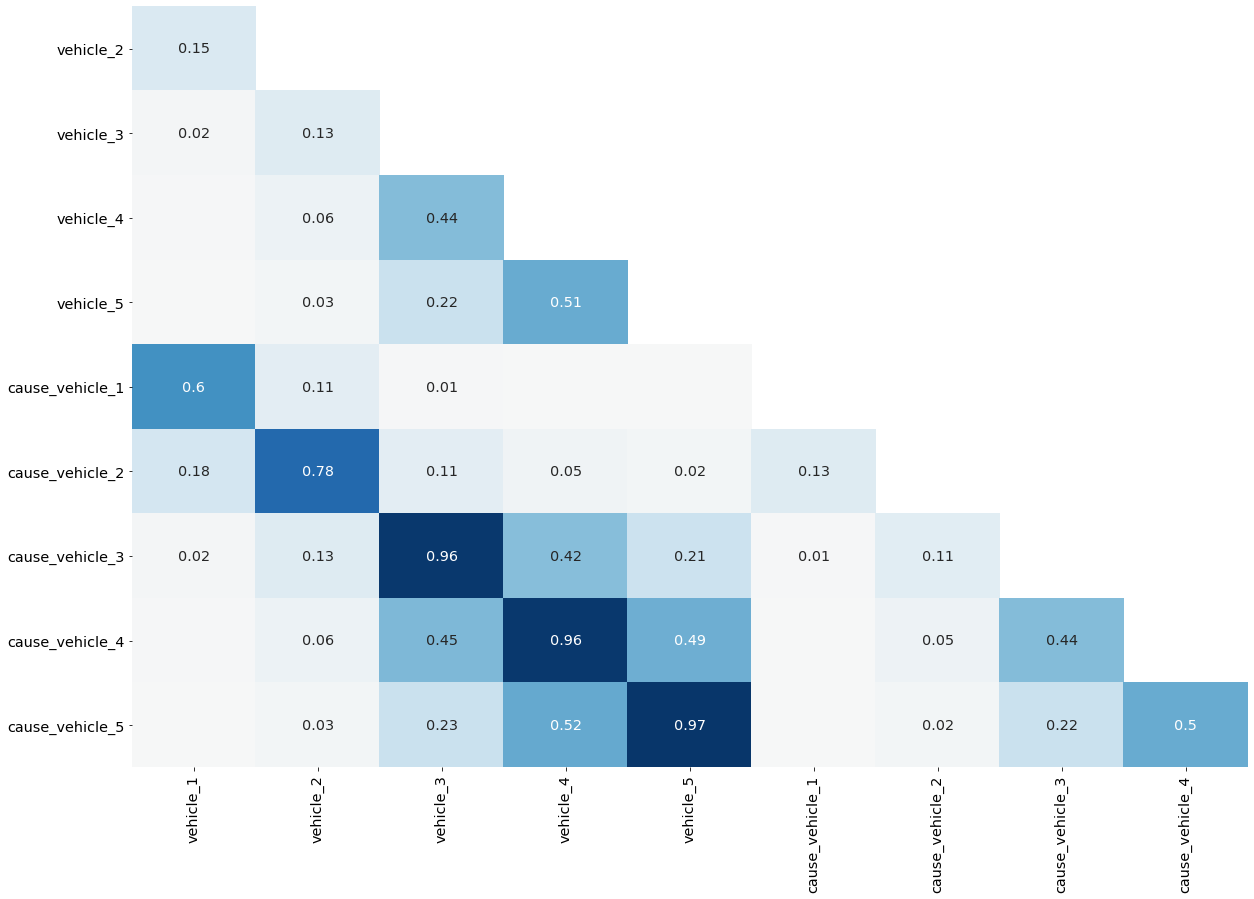

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
plot_null_correlations(mvc[[x for x in mvc.columns if 'vehicle' in x]])

In [11]:
col_labels= ['v_number', 'vehicle_missing', 'cause_missing']
vc_null_data= []
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])

vc_null_df = pd.DataFrame(vc_null_data, columns=col_labels)

In [12]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

df= mvc[v_cols].stack()

top10_vehicles=df.value_counts().head(10)

In [13]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
     
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()

    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, "Unspecified")

summary_after = summarize_missing()

In [14]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

for x in location_cols:
    mvc[x]=mvc[x].mask(mvc[x].isnull(),sup_data[x])
null_after= mvc[location_cols].isnull().sum()